# ModelT_RMSOptimizerComData_executado.ipynb-1

Aqui montamos o Google Drive no ambiente do Colab. Assim acedemos aos arquivos do seu Google Drive diretamente do notebook do Colab.
Na parecela seguinte descompactamos as imagens.


In [3]:
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!unzip imagens.zip

A saída de streaming foi truncada nas últimas 5000 linhas.
 extracting: imagens/validation/004_deer/woodland_caribou_s_001564.png  
   creating: imagens/validation/005_dog/
 extracting: imagens/validation/005_dog/blenheim_spaniel_s_000006.png  
 extracting: imagens/validation/005_dog/blenheim_spaniel_s_000039.png  
 extracting: imagens/validation/005_dog/blenheim_spaniel_s_000107.png  
 extracting: imagens/validation/005_dog/blenheim_spaniel_s_000129.png  
 extracting: imagens/validation/005_dog/blenheim_spaniel_s_000232.png  
 extracting: imagens/validation/005_dog/blenheim_spaniel_s_000260.png  
 extracting: imagens/validation/005_dog/blenheim_spaniel_s_000268.png  
 extracting: imagens/validation/005_dog/blenheim_spaniel_s_000322.png  
 extracting: imagens/validation/005_dog/blenheim_spaniel_s_000325.png  
 extracting: imagens/validation/005_dog/blenheim_spaniel_s_000352.png  
 extracting: imagens/validation/005_dog/blenheim_spaniel_s_000365.png  
 extracting: imagens/validation/005

# ModelT_RMSOptimizerComData_executado.ipynb-2

Este bloco de código define os caminhos para as pastas de treino, validação e teste. Estas pastas estão localizadas dentro do diretório base "/content/imagens", que é o local onde as imagens foram descompactadas.


In [28]:
base_dir = '/content/imagens'  # Diretório base após descompactação
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# ModelT_RMSOptimizerComData_executado.ipynb-3

São carregados os conjuntos de dados de treino, validação e teste a partir das pastas especificadas. Usamos a função "image_dataset_from_directory" do Keras para carregar as imagens, redimensioná-las para o tamanho especificado (150x150 neste caso) e agrupá-las em lotes de 32.

In [29]:
from keras.utils import image_dataset_from_directory
IMG_SIZE = 150
train_dataset = image_dataset_from_directory(
    train_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
)
validation_dataset = image_dataset_from_directory(
    validation_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
)
test_dataset = image_dataset_from_directory(
    test_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
)

Found 40000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.


# ModelT_RMSOptimizerComData_executado.ipynb-4

Aqui define-se e compila-se um modelo de aprendizagem profunda usando a arquitetura VGG16 como base. O modelo é composto por uma camada de entrada, seguida por uma camada de aumento de dados, uma camada de pré-processamento VGG16, uma camada de achatamento e duas camadas densas.


In [30]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
import numpy as np
import tensorflow as tf  # Import TensorFlow explicitly

from tensorflow.keras.applications import VGG16  # Correct import statement for VGG16

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
conv_base.trainable = False


data_augmentation = keras.Sequential(
 [
 layers.RandomFlip("horizontal"),
 layers.RandomRotation(0.1),
 layers.RandomZoom(0.2),
 ]
)

# Definição do modelo denso a partir das características extraídas
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs, outputs)

# ModelT_RMSOptimizerComData_executado.ipynb-5

Aqui compilamos o modelo de aprendizagem profunda que definimos anteriormente. Ele usa o otimizador RMSprop com uma taxa de aprendizagem de 0.0001, a função de perda "sparse_categorical_crossentropy"  e rastreia a métrica de "accuracy" durante o treino.


In [31]:
from tensorflow.keras.optimizers import RMSprop

model.compile(
    optimizer=RMSprop(),  # Use RMSprop optimizer
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# ModelT_RMSOptimizerComData_executado.ipynb-6

São definidos três callbacks que serão usados durante o treino do modelo.

O primeiro é o "ReduceLROnPlateau", que reduz a taxa de aprendizagem quando a perda dq validação não melhora após um determinado número de épocas ("patience"). O fator pelo qual a taxa de aprendizagem é reduzida é especificado pelo factor, e a taxa de aprendizagem mínima é especificada pelo "min_lr".

O segundo é o "EarlyStopping", que interrompe o treino quando a perda da validação não melhora após um determinado número de épocas ("patience"). Ele também restaura os pesos do modelo para o ponto onde a perda da validação foi a menor.

O terceiro é o "ModelCheckpoint", que guarda o modelo após cada época. Está configurado para guardar apenas o melhor modelo, com base na perda da validação ("val_loss").

O quarto treina o modelo de aprendizagem profunda que definimos e compilámos anteriormente. Usamos o conjunto de dados de treino "train_dataset" e o conjunto de dados de validação "validation_dataset". O modelo é treinado por 50 épocas, e os callbacks que definimos anteriormente são usados para controlar o treino.



In [32]:
from keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=0.001
)

In [33]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

In [34]:
from keras.callbacks import ModelCheckpoint

model_checkpoint = ModelCheckpoint(
    filepath='models/ModelT_RMSpropOptimizerComData.h5',
    save_best_only=True,
    monitor='val_loss'
)

In [35]:
callbacks = [reduce_lr, early_stopping, model_checkpoint]

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
1250/1250 [==============================] - 115s 90ms/step - loss: 1.6746 - accuracy: 0.6328 - val_loss: 0.9614 - val_accuracy: 0.7996 - lr: 0.0010


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/50
1250/1250 [==============================] - 132s 106ms/step - loss: 1.3347 - accuracy: 0.7061 - val_loss: 1.0627 - val_accuracy: 0.8285 - lr: 0.0010
Epoch 3/50
1250/1250 [==============================] - 114s 91ms/step - loss: 1.3129 - accuracy: 0.7257 - val_loss: 0.8944 - val_accuracy: 0.8446 - lr: 0.0010
Epoch 4/50
1250/1250 [==============================] - 112s 89ms/step - loss: 1.3098 - accuracy: 0.7336 - val_loss: 1.0175 - val_accuracy: 0.8418 - lr: 0.0010
Epoch 5/50
1250/1250 [==============================] - 112s 89ms/step - loss: 1.3436 - accuracy: 0.7384 - val_loss: 1.0289 - val_accuracy: 0.8462 - lr: 0.0010
Epoch 6/50
1250/1250 [==============================] - 112s 89ms/step - loss: 1.3338 - accuracy: 0.7458 - val_loss: 1.0364 - val_accuracy: 0.8359 - lr: 0.0010
Epoch 7/50
1250/1250 [==============================] - 111s 89ms/step - loss: 1.3571 - accuracy: 0.7420 - val_loss: 1.0533 - val_accuracy: 0.8416 - lr: 0.0010
Epoch 8/50
1250/1250 [=================

# ModelT_RMSOptimizerComData_executado.ipynb-7

Aqui criamos gráficos para visualizar a precisão e a perda durante o treino e a validação.

O primeiro bloco de código cria um gráfico da precisão de treino e validação ao longo das épocas.

O segundo bloco de código cria um gráfico da perda de treino e validação ao longo das épocas.

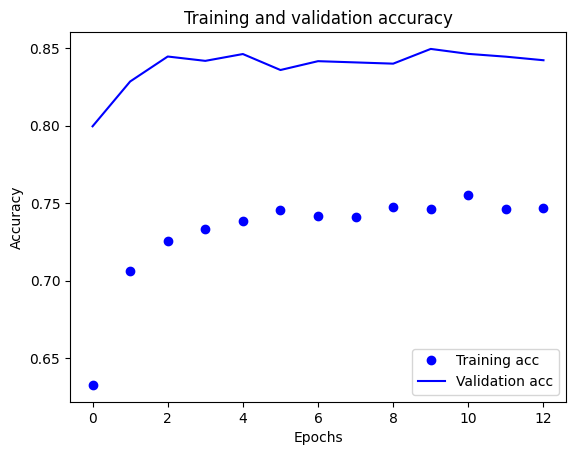

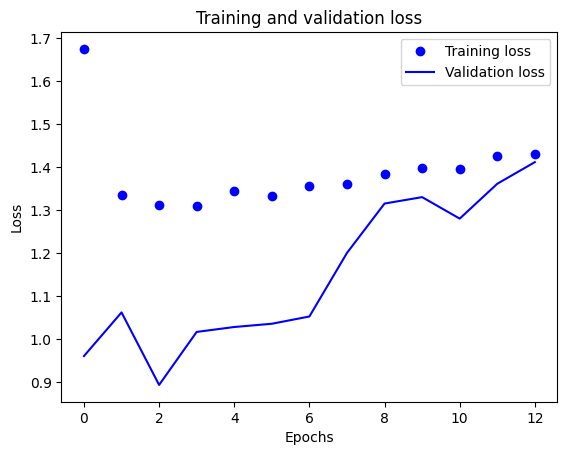

In [36]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], 'bo', label='Training acc')
plt.plot(history.history['val_accuracy'], 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], 'bo', label='Training loss')
plt.plot(history.history['val_loss'], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# ModelT_RMSOptimizerComData_executado.ipynb-8

Aqui avaliamos o desempenho do modelo treinado nos conjuntos de teste e validação.

O primeiro bloco de código avalia o modelo no conjunto de validação "validation_dataset" e imprime a perda e a precisão.

O segundo bloco de código avalia o modelo no conjunto de teste "test_dataset" e imprime a perda e a precisão.


In [37]:
val_loss, val_acc = model.evaluate(validation_dataset)
print('Validation Accuracy:', val_acc)


313/313 [==============================] - 22s 69ms/step - loss: 0.8944 - accuracy: 0.8446
Validation Accuracy: 0.8446000218391418


In [38]:
loss, accuracy = model.evaluate(test_dataset)
print(f"Loss: {loss}, Accuracy: {accuracy}")

313/313 [==============================] - 22s 69ms/step - loss: 0.8187 - accuracy: 0.8432
Loss: 0.8187240958213806, Accuracy: 0.8432000279426575


# ModelT_RMSOptimizerComData_executado.ipynb-9

Avalia.se o desempenho do modelo treinado e visualizando os resultados.

O código começa por importar as bibliotecas necessárias e definindo uma função "evaluate_model" que recebe um modelo e um conjunto de dados, faz previsões para todas as imagens no conjunto de dados e retorna os rótulos verdadeiros e previstos.

Em seguida, ele usa a função "evaluate_model" para obter os rótulos verdadeiros e previstos para o conjunto de teste "test_dataset".

O código então calcula a matriz de confusão e a visualiza usando um mapa de calor.

Finalmente, imprime-se um relatório de classificação e visualiza-se a precisão, a revocação e o F1-score para cada classe.

# Análise dos Resultados

Os resultados mostram a precisão, recall e F1-score para cada uma das 10 classes, bem como a precisão geral do modelo.

A precisão é a proporção de previsões corretas para uma determinada classe em relação a todas as previsões para essa classe. O recall é a proporção de previsões corretas para uma determinada classe em relação a todas as instâncias reais dessa classe. O F1-score é a média harmónica entre precisão e recall, fornecendo um equilíbrio entre estas duas métricas.

A precisão geral é a proporção de previsões corretas em relação a todas as previsões feitas.

Aqui estão algumas observações sobre os resultados:

- A classe 1, 8 e 9 (segunda, oitava e nona linhas) têm a maior precisão, o que significa que o modelo é muito bom a prever estas classes corretamente.
- A classe 3 (quarta linha) tem o menor recall, o que significa que o modelo tem dificuldade em identificar esta classe corretamente.
- A classe 6 (sétima linha) tem o maior F1-score, o que significa que o modelo tem um bom equilíbrio entre precisão e recall para esta classe.
- A precisão geral do modelo é de 0.84, o que significa que o modelo faz previsões corretas para 84% das instâncias no conjunto de teste.

Estes resultados podem ser usados para identificar onde o modelo está a ter um bom desempenho e onde pode ser necessário mais trabalho para melhorar o desempenho.


1/1 [==============================] - 0s 152ms/step


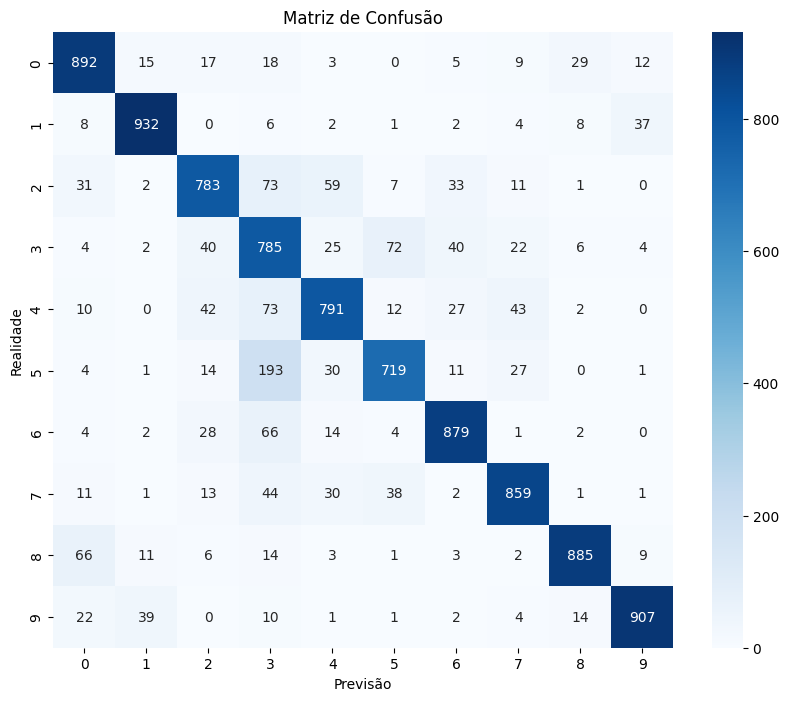

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1000
           1       0.93      0.93      0.93      1000
           2       0.83      0.78      0.81      1000
           3       0.61      0.79      0.69      1000
           4       0.83      0.79      0.81      1000
           5       0.84      0.72      0.78      1000
           6       0.88      0.88      0.88      1000
           7       0.87      0.86      0.87      1000
           8       0.93      0.89      0.91      1000
           9       0.93      0.91      0.92      1000

    accuracy                           0.84     10000
   macro avg       0.85      0.84      0.84     10000
weighted avg       0.85      0.84      0.84     10000



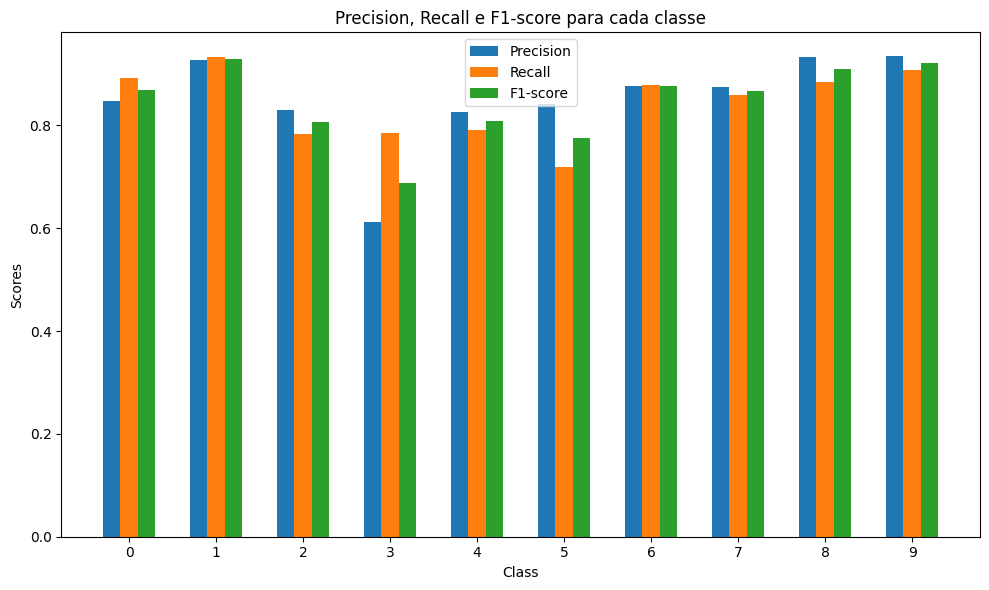

In [39]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Function to evaluate the model and get true and predicted labels
def evaluate_model(model, dataset):
    all_labels = []
    all_predictions = []

    for images, labels in dataset:
        predictions = model.predict(images)
        predicted_labels = np.argmax(predictions, axis=1)
        true_labels = labels.numpy()  # Convert to numpy array if not already

        all_labels.extend(true_labels)
        all_predictions.extend(predicted_labels)

    return np.array(all_labels), np.array(all_predictions)

# Get true and predicted labels for the test dataset
true_labels, predicted_labels = evaluate_model(model, test_dataset)

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.title('Matriz de Confusão')
plt.xlabel('Previsão')
plt.ylabel('Realidade')
plt.show()

# Print classification report
class_names = [str(i) for i in range(10)]  # Define class names based on your dataset
print(classification_report(true_labels, predicted_labels, target_names=class_names))

# Extract precision, recall, and F1-score for each class from classification report
report = classification_report(true_labels, predicted_labels, target_names=class_names, output_dict=True)

metrics = {'precision': [], 'recall': [], 'f1-score': []}
for cls in class_names:
    metrics['precision'].append(report[cls]['precision'])
    metrics['recall'].append(report[cls]['recall'])
    metrics['f1-score'].append(report[cls]['f1-score'])

# Plot precision, recall, and F1-score
plt.figure(figsize=(10, 6))
bar_width = 0.2
index = np.arange(len(class_names))

plt.bar(index, metrics['precision'], bar_width, label='Precision')
plt.bar(index + bar_width, metrics['recall'], bar_width, label='Recall')
plt.bar(index + 2*bar_width, metrics['f1-score'], bar_width, label='F1-score')

plt.xlabel('Class')
plt.ylabel('Scores')
plt.title('Precision, Recall e F1-score para cada classe')
plt.xticks(index + bar_width, class_names)
plt.legend()

plt.tight_layout()
plt.show()
